# JSON Serialization

In [1]:
import numpy as np
import pulser
from pulser import Pulse, Sequence, Register
from pulser.waveforms import BlackmanWaveform
from pulser.devices import Chadoq2
from pulser.json.abstract_repr.serializer import serialize_abstract_sequence
from pulser.json.abstract_repr.deserializer import deserialize_abstract_sequence

Often times, it is useful to import/export a given `Sequence` between different locations. To enable this, the `Sequence` object supports **serialization** and **deserialization** into JSON-formatted strings. This will work for any given `Sequence`. Take for example, this sequence that creates the Bell state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$:

c:\users\antoinecornillot\documents\pulser-fork2\pulser\pulser-core\pulser\sequence\sequence.py:942: UserWarning: A duration of 725 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 728 ns.
  self._add(pulse, channel, protocol)
c:\users\antoinecornillot\documents\pulser-fork2\pulser\pulser-core\pulser\sequence\sequence.py:942: UserWarning: A duration of 725 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 728 ns.
  self._add(pulse, channel, protocol)


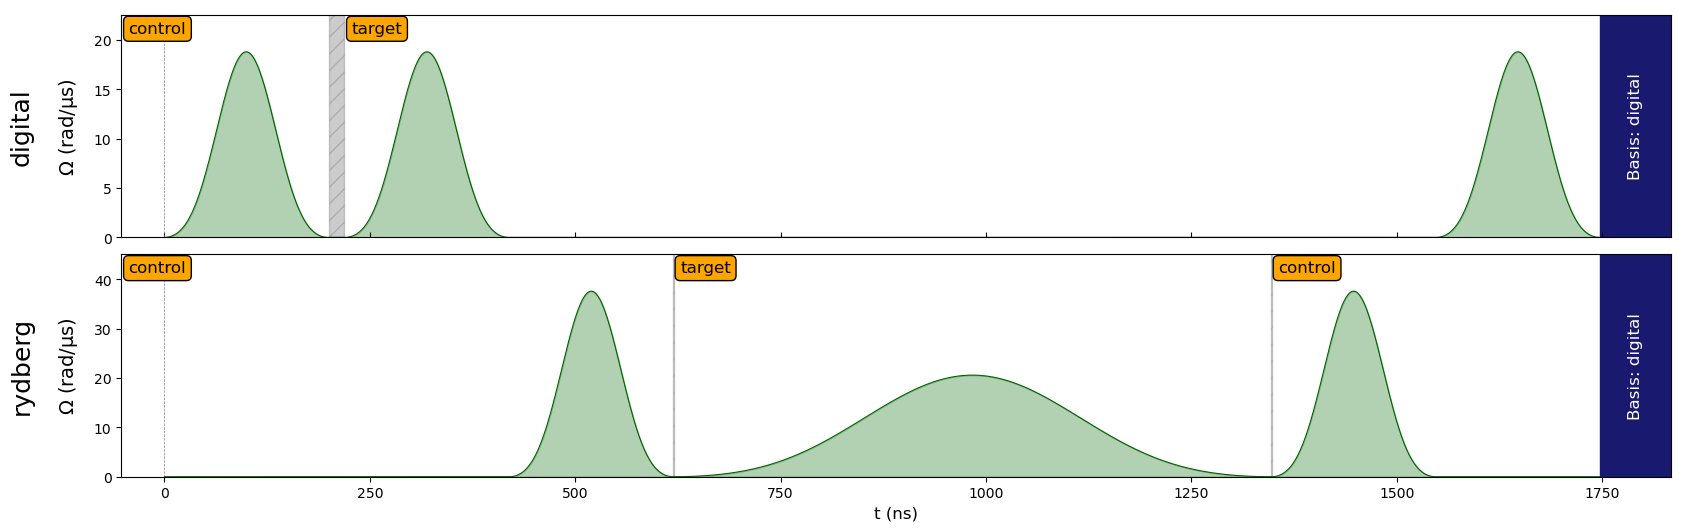

In [9]:
qubits = {"control": (-2, 0), "target": (2, 0)}
reg = Register(qubits)

seq = Sequence(reg, Chadoq2)
pulse_area = seq.declare_variable("pulse_phase", dtype=float)
seq.declare_channel("digital", "raman_local", initial_target="control")
seq.declare_channel("rydberg", "rydberg_local", initial_target="control")

half_pi_wf = BlackmanWaveform(200, area=np.pi/2)

ry = Pulse.ConstantDetuning(amplitude=half_pi_wf, detuning=0, phase=-pulse_area)
ry_dag = Pulse.ConstantDetuning(
    amplitude=half_pi_wf, detuning=0, phase=pulse_area
)

seq.add(ry, "digital")
seq.target("target", "digital")
seq.add(ry_dag, "digital")

pi_wf = BlackmanWaveform(200, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

max_val = Chadoq2.rabi_from_blockade(8)
two_pi_wf = BlackmanWaveform.from_max_val(max_val, 2 * np.pi)
two_pi_pulse = Pulse.ConstantDetuning(two_pi_wf, 0, 0)

seq.align("digital", "rydberg")
seq.add(pi_pulse, "rydberg")
seq.target("target", "rydberg")
seq.add(two_pi_pulse, "rydberg")
seq.target("control", "rydberg")
seq.add(pi_pulse, "rydberg")

seq.align("digital", "rydberg")
seq.add(ry, "digital")
seq.measure("digital")
seq1 = seq.build(pulse_phase=np.pi/2)
seq1.draw()

## Serialize

The former version of converting a `Sequence` into a JSON-formatted string was to use the `serialize` method. It is still supported, but a new method named `to_abstract_repr` should be used to have a more human-readable JSON object. Let's compare both serialization methods for 180 characters:

In [10]:
s = seq.serialize(indent=1)
print(s[:180], "...")

{
 "_build": true,
 "__module__": "pulser.sequence",
 "__name__": "Sequence",
 "__args__": [],
 "__kwargs__": {
  "register": {
   "_build": true,
   "__module__": "pulser.register ...


In [11]:
s_readable = seq.to_abstract_repr(json_dumps_options={"indent":1})
print(s_readable[:180], "...")

{
 "version": "1",
 "name": "pulser-exported",
 "register": [
  {
   "name": "control",
   "x": -2.0,
   "y": 0.0
  },
  {
   "name": "target",
   "x": 2.0,
   "y": 0.0
  }
 ],
 "c ...


It can be seen that the method `to_abstract_repr` is more explicit than `serialize` and should be favored when serializing a `Sequence`.

We can note that it is possible to provide optional parameters of `json.dumps` such as `indent` to both methods. In `serialize`, they should be provided as optional arguments whereas for `to_abstract_repr` they should be defined as a dictionnary in the argument `json_dumps_options`.

The method `to_abstract_repr` has more options. It is possible to change the name of the abstract sequence created as a JSON object (`seq_name`), to assign values to some declared variables in the case of a parametrized `Sequence`, or even to assign qubits to trap ids when the register is a `MappableRegister` (by defining a dictionary of `qubits`).

In [12]:
s1_readable = seq.to_abstract_repr(
    seq_name="BuiltSequence",
    json_dumps_options={"indent":1},
    pulse_phase=np.pi/2
    )
print(s1_readable)

{
 "version": "1",
 "name": "BuiltSequence",
 "register": [
  {
   "name": "control",
   "x": -2.0,
   "y": 0.0
  },
  {
   "name": "target",
   "x": 2.0,
   "y": 0.0
  }
 ],
 "channels": {
  "digital": "raman_local",
  "rydberg": "rydberg_local"
 },
 "variables": {
  "pulse_phase": {
   "type": "float",
   "value": [
    1.5707963267948966
   ]
  }
 },
 "operations": [
  {
   "op": "target",
   "channel": "digital",
   "target": 0
  },
  {
   "op": "target",
   "channel": "rydberg",
   "target": 0
  },
  {
   "op": "pulse",
   "channel": "digital",
   "protocol": "min-delay",
   "post_phase_shift": 0.0,
   "amplitude": {
    "kind": "blackman",
    "duration": 200,
    "area": 1.5707963267948966
   },
   "detuning": {
    "kind": "constant",
    "duration": 0,
    "value": 0
   },
   "phase": {
    "expression": "neg",
    "lhs": {
     "expression": "index",
     "lhs": {
      "variable": "pulse_phase"
     },
     "rhs": 0
    }
   }
  },
  {
   "op": "target",
   "channel": "digit

c:\users\antoinecornillot\documents\pulser-fork2\pulser\pulser-core\pulser\sequence\sequence.py:942: UserWarning: A duration of 725 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 728 ns.
  self._add(pulse, channel, protocol)


## Deserialize

The generated strings contain all the necessary information for recreating the original sequence elsewhere (it could, for example, be saved to a file and then imported). In the case of strings obtained from `Sequence.seralize`, one could recover the sequence `seq` by calling `Sequence.deserialize`. This method is still supported. However, to recover the sequence `seq` from `s_readable` (converted into JSON using `Sequence.to_abstract_repr`), one should use `Sequence.from_abstract_repr`. 

c:\users\antoinecornillot\documents\pulser-fork2\pulser\pulser-core\pulser\sequence\sequence.py:942: UserWarning: A duration of 725 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 728 ns.
  self._add(pulse, channel, protocol)
c:\users\antoinecornillot\documents\pulser-fork2\pulser\pulser-core\pulser\sequence\sequence.py:942: UserWarning: A duration of 725 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 728 ns.
  self._add(pulse, channel, protocol)


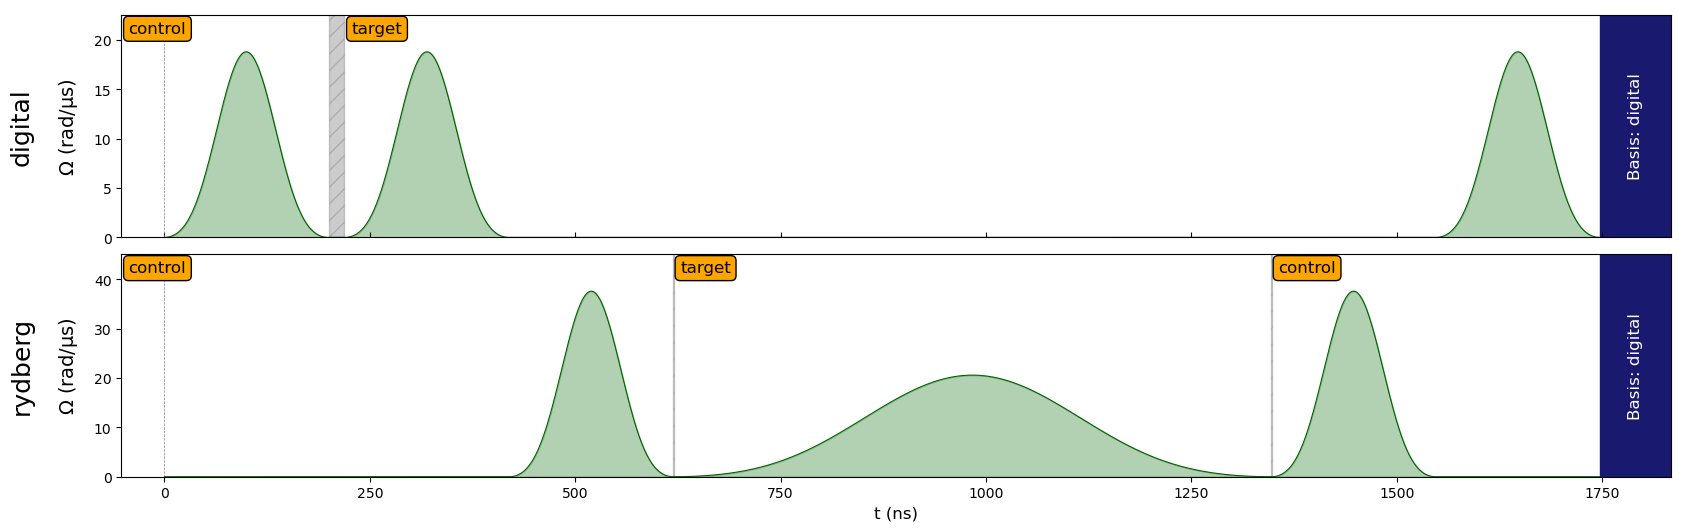

In [15]:
recovered_seq = Sequence.deserialize(s)
recovered_seq.build(pulse_phase=np.pi/2).draw()

In [16]:
recovered_seq_from_readable = Sequence.from_abstract_repr(s_readable)
recovered_seq_from_readable.build(pulse_phase=np.pi/2).draw()

ValueError: A waveform must have a positive duration, not 0.

In [17]:
Sequence.from_abstract_repr(s1_readable).draw()

ValueError: A waveform must have a positive duration, not 0.